In [1]:
!pip install -U tensorflow==2.17 #2.15 17 - wehere wixed tf lite coverter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.6 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras
import seaborn as sns

#models 
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB3, EfficientNetB5

#preproces
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


from collections import Counter
# for proper loading img
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



In [3]:
tf.__version__,

('2.17.0',)

## Data Load

In [4]:
SIZE = 320 #300
BS = 32 #16
imgs = glob(r'/kaggle/input/food41/images/*/*')
labels = [el.split('/')[5] for el in imgs ]

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.5, random_state=11, stratify=labels)
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])

datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        zoom_range=0.15,)
valid_gen = ImageDataGenerator(rescale=1./255)



train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=True)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=False)

model = tf.keras.models.load_model('/kaggle/input/food101_efb3_030325_p10/tensorflow2/default/1/food101_efb3_030325_p10.h5')

Found 50500 validated image filenames belonging to 101 classes.
Found 50500 validated image filenames belonging to 101 classes.


## Train

In [5]:

loss = tf.keras.losses.CategoricalFocalCrossentropy(gamma=6, from_logits=False)
learning_rate = 6.0000e-04  
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)   
model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)



early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True, start_from_epoch=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, min_lr=1.0000e-08) #0
epoch = 10
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop, reduce_lr],  batch_size = BS )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2529s 1s/step - accuracy: 0.3878 - loss: 9.1325 - val_accuracy: 0.5390 - val_loss: 8.5724 - learning_rate: 6.0000e-04
Epoch 2/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2233s 1s/step - accuracy: 0.4454 - loss: 8.7432 - val_accuracy: 0.5953 - val_loss: 8.9299 - learning_rate: 6.0000e-04
Epoch 3/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2233s 1s/step - accuracy: 0.4896 - loss: 8.6899 - val_accuracy: 0.6176 - val_loss: 8.8070 - learning_rate: 6.0000e-04
Epoch 4/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2233s 1s/step - accuracy: 0.5601 - loss: 5.3152 - val_accuracy: 0.6908 - val_loss: 5.2345 - learning_rate: 3.6000e-04
Epoch 5/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2230s 1s/step - accuracy: 0.5878 - loss: 5.2575 - val_accuracy: 0.7058 - val_loss: 5.2165 - learning_rate: 3.6000e-04
Epoch 6/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2232s 1s/step - accuracy: 0.6152 - loss: 5.2348 - val_accuracy: 0.7237 - val_loss: 5.1750 - learning_rate: 3.6000e-04
Epoch 7/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2230s 1s/

In [6]:
model.save('food101_efb3_p25.keras')

In [7]:
model.save_weights('weights_food101_efb3_e20.weights.h5')


## Metrics

In [9]:
val = model.evaluate(test_gen)
test = model.evaluate(train_gen)

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 450s 285ms/step - accuracy: 0.7444 - loss: 3.2514
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1359s 860ms/step - accuracy: 0.8757 - loss: 3.1102


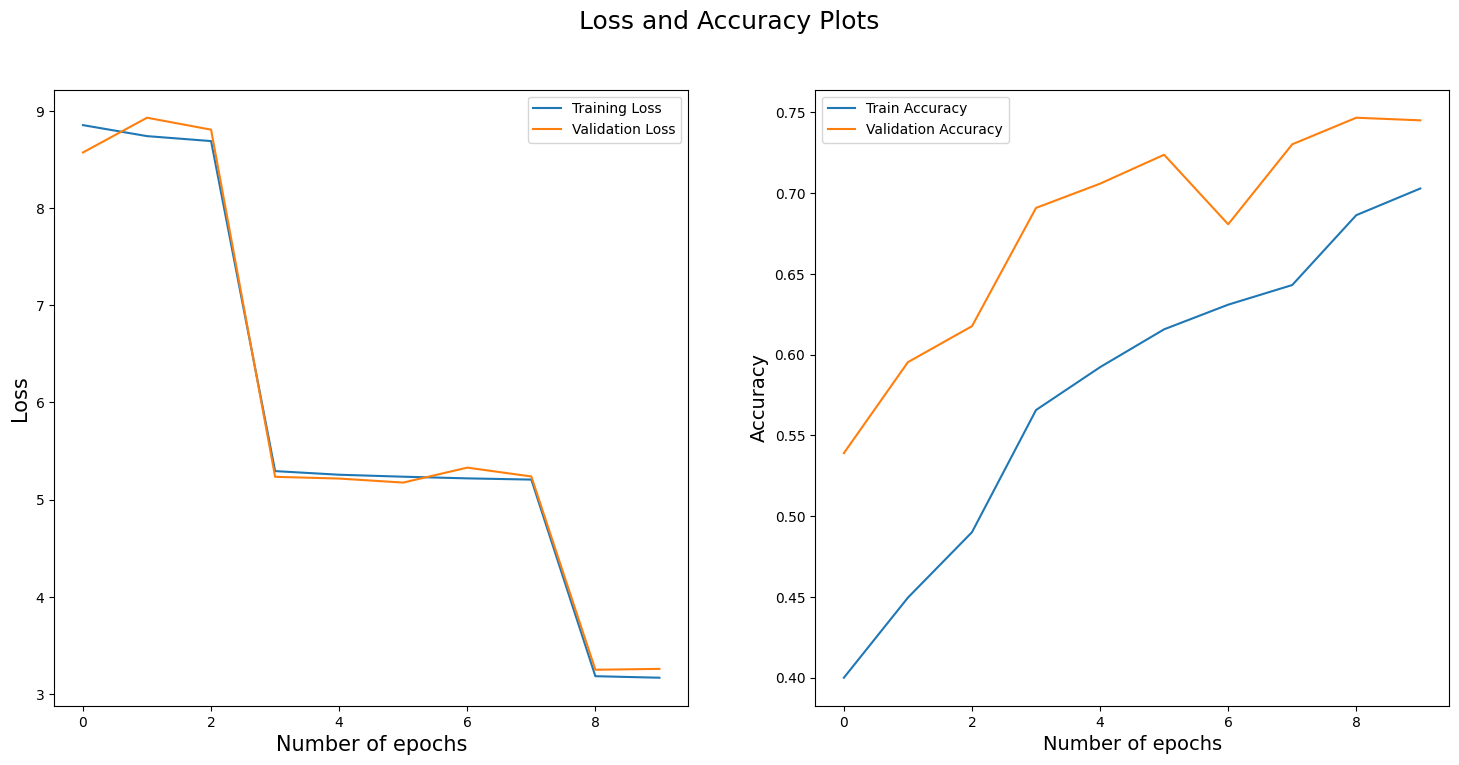

In [8]:
def show_history(history):
    plt.figure(figsize=(18,8))

    plt.suptitle('Loss and Accuracy Plots', fontsize=18)

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

show_history(history)